# chips-net analysis

This notebook outlines the main findings from chips-net and the path taken to get to the final version.

This notebook contains the following sections...

- Data loading and model inference
- Exploring the data (true distributions, different representations etc...)
- 

This notebook requires the following models trained and defined in the eval.yaml file...

Currently these are all trained for 5 epochs using 320000 events, I need to up this!
Need to do this for 10 epochs using 1920000 images

- t_all_cat classifier, vertex charge, using uniform sample *
- t_all_cat classifier, vertex charge + time, using uniform sample *
- t_all_cat classifier, origin charge + time, using uniform sample *
- t_all_cat classifier, iso charge + time, using uniform sample *
- t_all_cat classifier, vertex charge + time + hough, using uniform sample *

- t_all_cat classifier, vertex charge + time + hough, using beam sample *
- t_cosmic_cat classifier, vertex charge + time + hough, using uniform sample
- t_cosmic_cat classifier, vertex charge + time + hough, using beam sample
- multi-class classifier, vertex charge + time + hough, using uniform sample
- multi-class classifier, vertex charge + time + hough, using beam sample

Once we have then found the input/sample that is best to use we can then look at other things...

- Random augmentation model
- Different archetecture (vgg, inception, efficientnet, resent, resnest, attention)

Need a method that takes (dataset, events_df, model, num_events) and produces the following...

- 

In [1]:
# Input parameters for this notebook...
config_path = "/mnt/storage/jtingey/chips-net/config/eval.yaml"

In [2]:
# Import the standard modules required
import time
import os
import sys
import logging
import importlib

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import mplhep as hep
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import ROOT
from root_pandas import to_root

# Setup Tensorflow and the GPU's for inference
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.disable(logging.CRITICAL)
gpus = tf.config.list_physical_devices('GPU')
if tf.config.list_physical_devices('GPU'):
    try:  # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:  # Memory growth must be set before GPUs have been initialized
        print(e)

# chipsnet imports
sys.path.insert(0, "/mnt/storage/jtingey/chips-net/")
import chipsnet.config
import chipsnet.data
import chipsnet.models
import chipsnet.utils

# Setup matplotlib style using mplhep
extra_styling = {
    "text.usetex": True,
    "pgf.texsystem": "pdflatex",
    "pgf.rcfonts": False
}
plt.style.use([hep.style.ROOT, extra_styling])

Welcome to JupyROOT 6.20/04


In [3]:
def reload():
    importlib.reload(chipsnet.config)
    importlib.reload(chipsnet.data)
    importlib.reload(chipsnet.models)
    importlib.reload(chipsnet.utils)

In [4]:
# Load the configuration and get all the dataframes and models
config = chipsnet.config.get(config_path)

# Get the data loaders for each of the datasets
bf_data = chipsnet.utils.data_from_conf(config, 'beam_flux')
bu_data = chipsnet.utils.data_from_conf(config, 'beam_uniform')

# Load data into the pandas dataframes
num_examples = int(config.eval.examples)
bf_events = bf_data.testing_df(num_events=num_examples)
bu_events = bu_data.testing_df(num_events=num_examples)

# Get all the models we want to use in evaluation
bf_model = chipsnet.utils.model_from_conf(config, 'beam_flux')
bu_model = chipsnet.utils.model_from_conf(config, 'beam_uniform')
bul_model = chipsnet.utils.model_from_conf(config, 'beam_uniform_long')
c_model = chipsnet.utils.model_from_conf(config, 'cosmic')

In [5]:
# Run inference on all the datasets through all the models
bf_events = chipsnet.utils.run_inference(bf_data, bf_events, bf_model, num_examples, prefix='bf_')
bf_events = chipsnet.utils.run_inference(bf_data, bf_events, bu_model, num_examples, prefix='bu_')
bf_events = chipsnet.utils.run_inference(bf_data, bf_events, bul_model, num_examples, prefix='bul_')
bf_events = chipsnet.utils.run_inference(bf_data, bf_events, c_model, num_examples)

bu_events = chipsnet.utils.run_inference(bu_data, bu_events, bf_model, num_examples, prefix='bf_')
bu_events = chipsnet.utils.run_inference(bu_data, bu_events, bu_model, num_examples, prefix='bu_')
bf_events = chipsnet.utils.run_inference(bf_data, bf_events, bul_model, num_examples, prefix='bul_')
bu_events = chipsnet.utils.run_inference(bu_data, bu_events, c_model, num_examples)

Running inference on multi_simple...took 18.07 seconds
Running inference on multi_simple...took 15.31 seconds
Running inference on multi_simple...took 15.43 seconds
Running inference on cosmic...took 15.03 seconds
Running inference on multi_simple...took 15.04 seconds
Running inference on multi_simple...took 15.02 seconds
Running inference on multi_simple...took 14.96 seconds
Running inference on cosmic...took 14.84 seconds


In [6]:
# Add the event weights to the dataframes so we can scale plots appropriately
bf_events = chipsnet.utils.apply_weights(bf_events)

Nuel number:   8362, weight: 0.00465
Anuel number:  6144, weight: 0.00041
Numu number:   9264, weight: 0.36196
Anumu number:  5016, weight: 0.01463
Cosmic number: 3214, weight: 376.695


In [7]:
# Apply the default cuts to the events
bf_events = chipsnet.utils.apply_standard_cuts(bf_events, phi_cut=0.001667)

Nuel-CC: total 12322, survived: 0.8082291835740951
Numu-CC: total 12369, survived: 0.5278518877839761
NC: total 4095, survived: 0.34627594627594627
Cosmic: total 3214, survived: 0.0


In [8]:
# Calculate the fully combined category scores (Nuel CC, Numu CC and NC)
bf_events = chipsnet.utils.full_comb_combine(bf_events, "bf_")
bf_events = chipsnet.utils.full_comb_combine(bf_events, "bu_")
bf_events = chipsnet.utils.full_comb_combine(bf_events, "bul_")

In [23]:
def plot_combined_values(events, prefix):
    bins = 40
    range=(0, 1)
    cat0 = prefix + "pred_t_comb_cat_0"
    cat1 = prefix + "pred_t_comb_cat_1"
    cat2 = prefix + "pred_t_comb_cat_2"
    nuel_cc_events = events[events["t_comb_cat"] == 0]
    numu_cc_events = events[events["t_comb_cat"] == 1]
    nc_events = events[events["t_comb_cat"] == 2]
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
    axs[0].hist(nuel_cc_events[cat0], weights=nuel_cc_events["w"], range=range, bins=bins, color='green', histtype='step')
    axs[0].hist(numu_cc_events[cat0], weights=numu_cc_events["w"], range=range, bins=bins, color='blue', histtype='step')
    axs[0].hist(nc_events[cat0], weights=nc_events["w"], range=range, bins=bins, color='red', histtype='step')
    axs[0].set_xlabel('Combined nuel cc score', fontsize=17)
    axs[0].set_yscale('log')
    
    axs[1].hist(nuel_cc_events[cat1], weights=nuel_cc_events["w"], range=range, bins=bins, color='green', histtype='step')
    axs[1].hist(numu_cc_events[cat1], weights=numu_cc_events["w"], range=range, bins=bins, color='blue', histtype='step')
    axs[1].hist(nc_events[cat1], weights=nc_events["w"], range=(0, 1), bins=bins, color='red', histtype='step')
    axs[1].set_xlabel('Combined numu cc score', fontsize=17)
    axs[1].set_yscale('log')
    
    axs[2].hist(nuel_cc_events[cat2], weights=nuel_cc_events["w"], range=range, bins=bins, color='green', histtype='step')
    axs[2].hist(numu_cc_events[cat2], weights=numu_cc_events["w"], range=range, bins=bins, color='blue', histtype='step')
    axs[2].hist(nc_events[cat2], weights=nc_events["w"], range=range, bins=bins, color='red', histtype='step')
    axs[2].set_xlabel('Combined nc score', fontsize=17)
    axs[2].set_yscale('log')

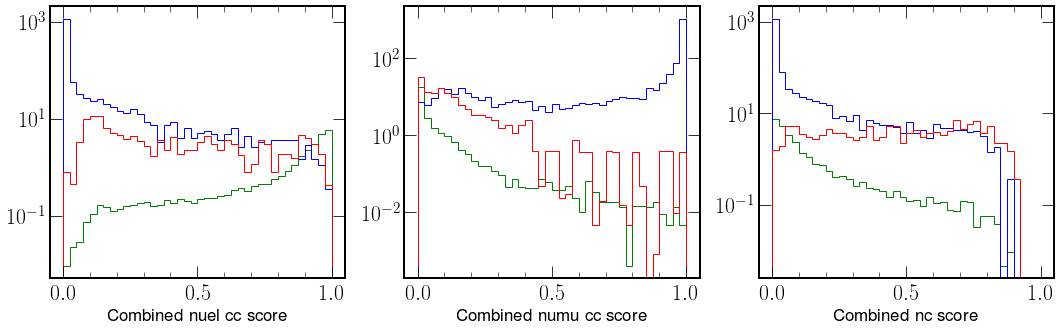

In [24]:
plot_combined_values(bf_events[bf_events.cut == 0], prefix="bf_")

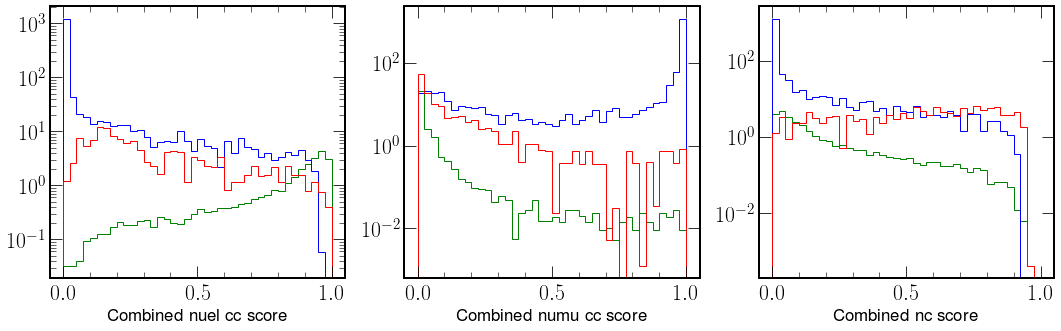

In [25]:
plot_combined_values(bf_events[bf_events.cut == 0], prefix="bu_")

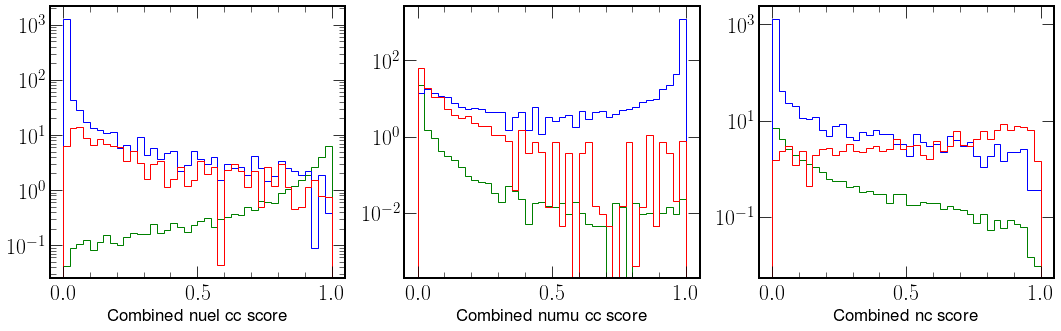

In [26]:
plot_combined_values(bf_events[bf_events.cut == 0], prefix="bul_")

In [9]:
reload()
cuts, bf_bf_sig_effs, bf_bf_bkg_effs, bf_bf_purities, bf_bf_foms = chipsnet.utils.calculate_curves(
    bf_events[bf_events.cut == 0], prefix="bf_")
time.sleep(1)
cuts, bf_bu_sig_effs, bf_bu_bkg_effs, bf_bu_purities, bf_bu_foms = chipsnet.utils.calculate_curves(
    bf_events[bf_events.cut == 0], prefix="bu_")
time.sleep(1)
cuts, bf_bul_sig_effs, bf_bul_bkg_effs, bf_bul_purities, bf_bul_foms = chipsnet.utils.calculate_curves(
    bf_events[bf_events.cut == 0], prefix="bul_")

--- calculating curves: 100%|██████████| 200/200 [00:03<00:00, 60.62it/s]
--- Maximum FOMS ---
Nuel-CC: 0.3178(0.9300)
Numu-CC: 0.9344(0.0900)
NC: 0.3525(0.2200)
Signal efficiency AUC: 0.832646766360253
Background efficiency AUC: 0.095742523072477
Purity AUC: 0.23817741667061035
FOM AUC: 0.16420792568426007
ROC AUC: -0.9771776045584883
--- calculating curves: 100%|██████████| 200/200 [00:03<00:00, 61.15it/s]
--- Maximum FOMS ---
Nuel-CC: 0.2995(0.9100)
Numu-CC: 0.9326(0.0250)
NC: 0.3954(0.2900)
Signal efficiency AUC: 0.7970929338683201
Background efficiency AUC: 0.0904303697027687
Purity AUC: 0.2493736314640434
FOM AUC: 0.15699485646517014
ROC AUC: -0.9747308507644333
--- calculating curves: 100%|██████████| 200/200 [00:03<00:00, 60.79it/s]--- Maximum FOMS ---
Nuel-CC: 0.3611(0.8450)
Numu-CC: 0.9436(0.0350)
NC: 0.4506(0.2600)
Signal efficiency AUC: 0.8203394907821124
Background efficiency AUC: 0.06528154701393653
Purity AUC: 0.3040684917009965
FOM AUC: 0.20979379337065956
ROC AUC: -0.9

In [10]:
def plot_combined_values(cuts, sig_effs_bf, sig_effs_bu, bkg_effs_bf, bkg_effs_bu):

    fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'hspace': 0.3})
    axs[0].plot(cuts, sig_effs_bf, color='green')
    axs[0].plot(cuts, bkg_effs_bf, color='red')
    axs[0].plot(cuts, sig_effs_bu, color='green', linestyle='dashed')
    axs[0].plot(cuts, bkg_effs_bu, color='red', linestyle='dashed')
    axs[0].set_xlabel('Combined nuel cc score', fontsize=17)
    axs[0].set_ylabel('Efficiency', fontsize=17)

    axs[1].plot(bkg_effs_bf, sig_effs_bf, color='black')
    axs[1].plot(bkg_effs_bu, sig_effs_bu, color='black', linestyle='dashed')
    axs[1].set_xlabel('Background efficiency', fontsize=17)
    axs[1].set_ylabel('Signal efficiency', fontsize=17)

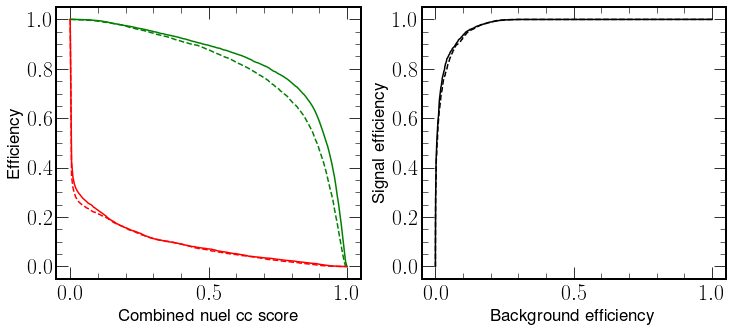

In [11]:
plot_combined_values(cuts, bf_bf_sig_effs[0], bf_bu_sig_effs[0], bf_bf_bkg_effs[0], bf_bu_bkg_effs[0])

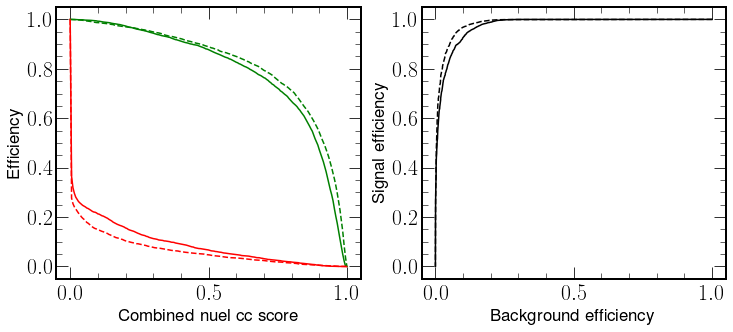

In [12]:
plot_combined_values(cuts, bf_bu_sig_effs[0], bf_bul_sig_effs[0], bf_bu_bkg_effs[0], bf_bul_bkg_effs[0])

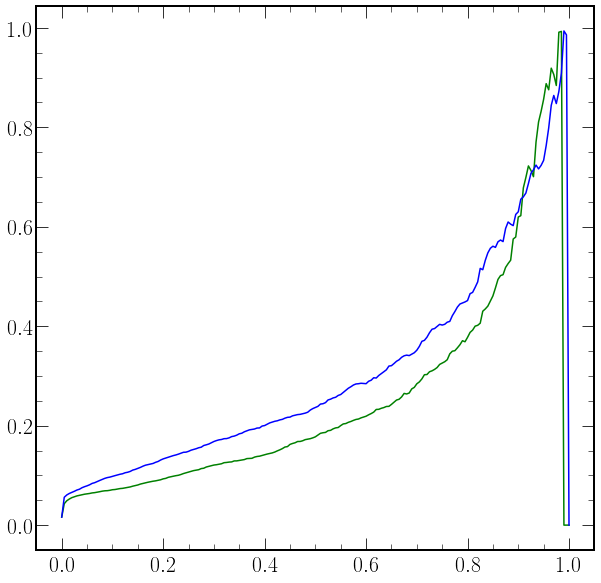

In [13]:
plt.plot(cuts, bf_bu_purities[0], color='green')
plt.plot(cuts, bf_bul_purities[0], color='blue')

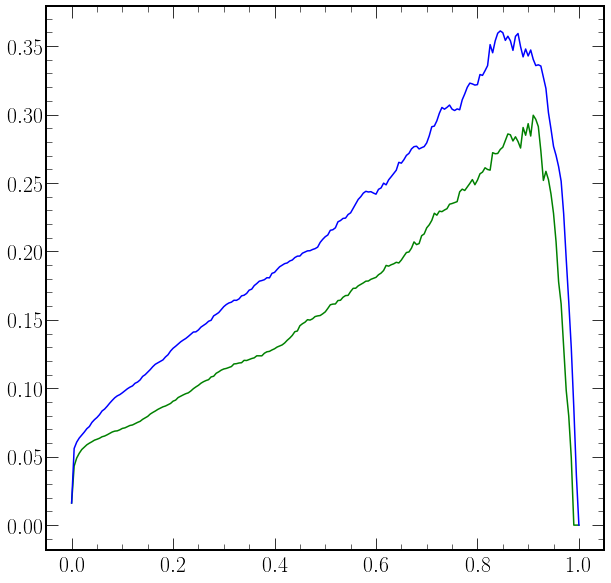

In [14]:
plt.plot(cuts, bf_bu_foms[0], color='green')
plt.plot(cuts, bf_bul_foms[0], color='blue')

## The input images

First let's explore the input event 'hit maps' we can use as input to the network.

Figuring out how best to represent the 2D surface of a cylindrical detector for a 2d convolutional network is a challenge.
The simplest approach would be to ignore the endcaps and just use a square/rectangular map of the detector barrel as input.
However, a large fraction of the Cherenkov light collected by the detector hits the endcaps so we will be loosing a lot of infomation...

In [32]:
# Setup the configuration variables for plotting the events
nuel_file = "/unix/chips/jtingey/production/beam_all/nuel/map/chips_1200/selected_000_sim_map.root"
numu_file = "/unix/chips/jtingey/production/beam_all/numu/map/chips_1200/selected_000_sim_map.root"
cosmic_file = "/unix/chips/jtingey/production/cosmic_all/map/chips_1200/selected_000_sim_map.root"
image_size = [64, 64]
images_dict = {
    "r_raw_charge_map_origin": [],
    "r_raw_charge_map_iso": [],
    "r_raw_charge_map_vtx": [],
    "r_raw_time_map_origin": [],
    "r_raw_time_map_iso": [],
    "r_raw_time_map_vtx": [],
    "r_raw_hit_hough_map_vtx": []
}
channel_hists = images_dict

In [33]:
# Load the images into the dictionary
import uproot
nuel_file = uproot.open(nuel_file)
numu_file = uproot.open(numu_file)
cosmic_file = uproot.open(cosmic_file)
for image_name in images_dict.keys():
    images_dict[image_name].extend(nuel_file['reco'].array(image_name))
    images_dict[image_name].extend(numu_file['reco'].array(image_name))
    images_dict[image_name].extend(cosmic_file['reco'].array(image_name))

# Calculate fraction of hits in the endcaps
cap_total = 0
barrel_total = 0
for event in images_dict['r_raw_charge_map_vtx']:
    sections = np.split(event, [18, 46], axis=0)
    cap_total += (sections[0].sum() + sections[2].sum())
    barrel_total += sections[1].sum()

# This is with cosmic events included
print("Fraction of deposited charge in endcaps = {}".format(cap_total/(cap_total+barrel_total)))

In [50]:
def plot_hit_time(images_dict, event):
    fig, axs = plt.subplots(2, 3, figsize=(16, 10), gridspec_kw={'hspace': 0.3})
    plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
    axs[0, 0].imshow(images_dict['r_raw_charge_map_origin'][event], cmap='Reds', origin='lower')
    axs[0, 0].set_title('$\phi$ and $\\theta$ from origin')
    axs[0, 0].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins')

    axs[0, 1].imshow(images_dict['r_raw_charge_map_iso'][event], cmap='Reds', origin='lower')
    axs[0, 1].set_title('$x^{+}$ and $x^{-}$ from origin')
    axs[0, 1].set(xlabel='$x^{+}$ bins', ylabel='$x^{-}$ bins')

    axs[0, 2].imshow(images_dict['r_raw_charge_map_vtx'][event], cmap='Reds', origin='lower')
    axs[0, 2].set_title('$\phi$ and $\\theta$ from vertex')
    axs[0, 2].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins')
    axs[0, 2].text(68, 3, 'Desposited charge images', rotation=-90, fontsize=18)

    axs[1, 0].imshow(images_dict['r_raw_time_map_origin'][event], cmap='Reds', origin='lower')
    axs[1, 0].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins')

    axs[1, 1].imshow(images_dict['r_raw_time_map_iso'][event], cmap='Reds', origin='lower')
    axs[1, 1].set(xlabel='$x^{+}$ bins', ylabel='$x^{-}$ bins')

    axs[1, 2].imshow(images_dict['r_raw_time_map_vtx'][event], cmap='Reds', origin='lower')
    axs[1, 2].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins')
    axs[1, 2].text(68, 10, 'First hit time images', rotation=-90, fontsize=18)
    
def plot_hough(images_dict, event):
    fig, axs = plt.subplots(1, 1, figsize=(5, 5), gridspec_kw={'hspace': 0.3})
    plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
    axs.imshow(images_dict['r_raw_hit_hough_map_vtx'][event], cmap='Reds', origin='lower')
    axs.set_title('$\phi$ and $\\theta$ from vertex')
    axs.set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins')
    axs.text(68, 13, 'Hough space image', rotation=-90, fontsize=18)

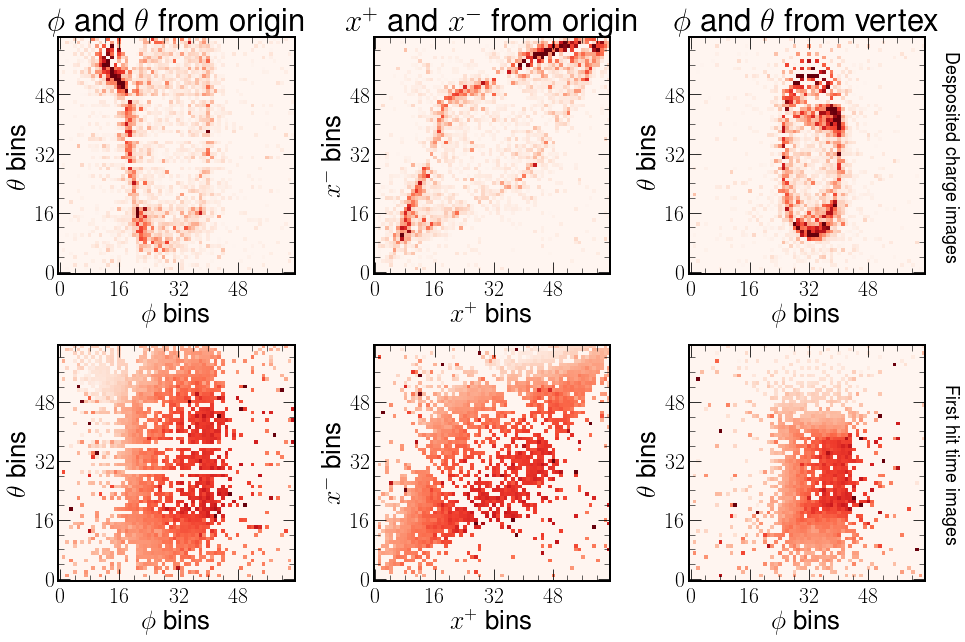

In [51]:
plot_hit_time(images_dict, 1)

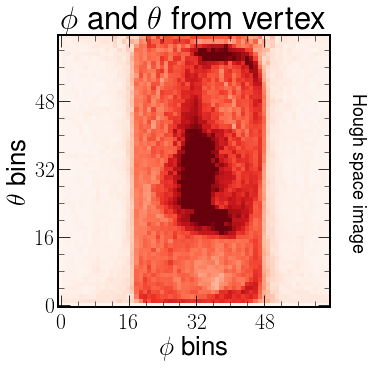

In [52]:
plot_hough(images_dict, 1)

### Defining ranges for 8-bit encoding

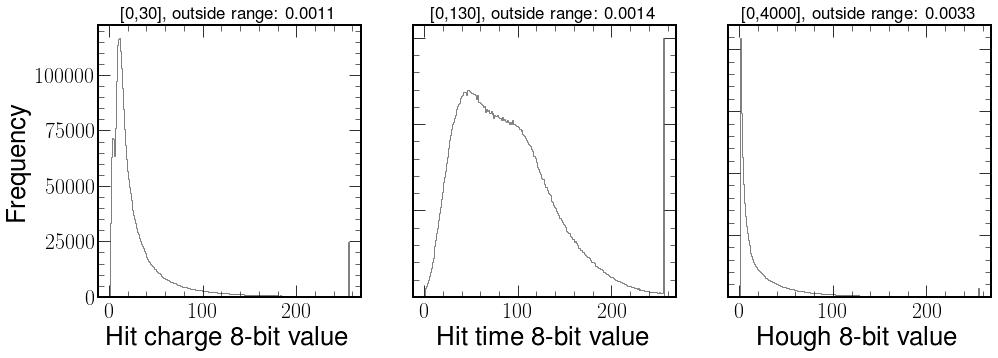

In [59]:
def plot_8bit_range(images_dict, max_charge=30, max_time=130, max_hough=4000):
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    #plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
    
    hist_data = []
    for event in images_dict['r_raw_charge_map_vtx']:
        hist_data.append(event.reshape(4096))
    hist_data = np.concatenate(hist_data, axis=0)
    occurrences = np.count_nonzero(hist_data == 255)/len(hist_data)
    axs[0].hist(hist_data, range=(1, 256), bins=255, color='grey', histtype='step')
    axs[0].set_title("[0,{}], outside range: {:.4f}".format(max_charge, occurrences), fontsize=17)
    axs[0].set(xlabel='Hit charge 8-bit value', ylabel='Frequency')
    axs[0].label_outer()
    
    hist_data = []
    for event in images_dict['r_raw_time_map_vtx']:
        hist_data.append(event.reshape(4096))
    hist_data = np.concatenate(hist_data, axis=0)
    occurrences = np.count_nonzero(hist_data == 255)/len(hist_data)
    axs[1].hist(hist_data, range=(1, 256), bins=255, color='grey', histtype='step')
    axs[1].set_title("[0,{}], outside range: {:.4f}".format(max_time, occurrences), fontsize=17)
    axs[1].set(xlabel='Hit time 8-bit value', ylabel='Frequency')
    axs[1].label_outer()
    
    hist_data = []
    for event in images_dict['r_raw_hit_hough_map_vtx']:
        hist_data.append(event.reshape(4096))
    hist_data = np.concatenate(hist_data, axis=0)
    occurrences = np.count_nonzero(hist_data == 255)/len(hist_data)
    axs[2].hist(hist_data, range=(1, 256), bins=255, color='grey', histtype='step')
    axs[2].set_title("[0,{}], outside range: {:.4f}".format(max_hough, occurrences), fontsize=17)
    axs[2].set(xlabel='Hough 8-bit value', ylabel='Frequency')
    axs[2].label_outer()

plot_8bit_range(images_dict)

## Explainability

In [29]:
from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity
from tf_explain.core.activations import ExtractActivations
from tf_explain.core.vanilla_gradients import VanillaGradients
from tf_explain.core.smoothgrad import SmoothGrad
from tf_explain.core.integrated_gradients import IntegratedGradients
from tf_explain.core.gradients_inputs import GradientsInputs


single_output_model = tf.keras.Model(
    inputs=bul_model.model.input,
    outputs=bul_model.model.get_layer('t_all_cat').output
)

grad_cams_1 = []
grad_cams_2 = []
grad_cams_3 = []
occlusions = []
activations_1 = []
activations_2 = []
activations_3 = []
vanilla_grads = []
smooth_grads = []
int_grads = []
imput_grads = []
for inputs, labels in bu_data.testing_ds(20):
    event_class = int(labels['t_all_cat'])
    image = tf.expand_dims(inputs['image_0'], axis=0).numpy()

    if event_class == 24:
        continue

    grad_cams_1.append(GradCAM().explain((image, event_class), single_output_model, class_index=event_class, layer_name="path0_block1"))
    grad_cams_2.append(GradCAM().explain((image, event_class), single_output_model, class_index=event_class, layer_name="path0_block2"))
    grad_cams_3.append(GradCAM().explain((image, event_class), single_output_model, class_index=event_class, layer_name="path0_block3"))
    occlusions.append(OcclusionSensitivity().explain((image, event_class), single_output_model, class_index=event_class, patch_size=3))
    activations_1.append(ExtractActivations().explain((image, event_class), single_output_model, layers_name='path0_block1_conv0'))
    activations_2.append(ExtractActivations().explain((image, event_class), single_output_model, layers_name='path0_block2_conv0'))
    activations_3.append(ExtractActivations().explain((image, event_class), single_output_model, layers_name='path0_block3_conv0'))
    vanilla_grads.append(VanillaGradients().explain((image, event_class), single_output_model, class_index=event_class))
    smooth_grads.append(SmoothGrad().explain((image, event_class), single_output_model, class_index=event_class))
    int_grads.append(IntegratedGradients().explain((image, event_class), single_output_model, class_index=event_class))
    imput_grads.append(GradientsInputs().explain((image, event_class), single_output_model, class_index=event_class))

[Text(0, 0.5, '$\\theta$ bins'),
 Text(0.5, 0, '$\\phi$ bins'),
 Text(0.5, 1.0, 'GradCam Block 3')]

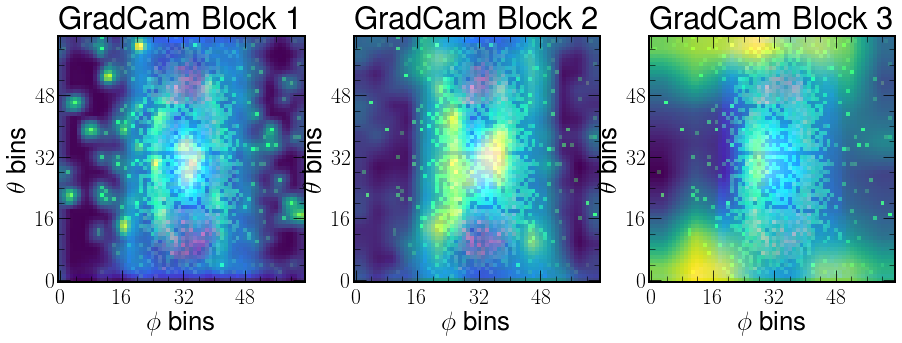

In [33]:
event = 11
fig, axs = plt.subplots(1, 3, figsize=(15, 12), gridspec_kw={'hspace': 0.3})
plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
axs[0].imshow(grad_cams_1[event], cmap='Reds', origin='lower')
axs[0].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 1')
axs[1].imshow(grad_cams_2[event], cmap='Reds', origin='lower')
axs[1].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 2')
axs[2].imshow(grad_cams_3[event], cmap='Reds', origin='lower')
axs[2].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 3')
#axs[1, 0].imshow(smooth_grads[event], cmap='Reds', origin='lower')
#axs[1, 0].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='Smooth gradients')
#axs[1, 1].imshow(int_grads[event], cmap='Reds', origin='lower')
#axs[1, 1].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='Int gradients')
#axs[1, 2].imshow(imput_grads[event], cmap='Reds', origin='lower')
#axs[1, 2].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='Input times gradients')

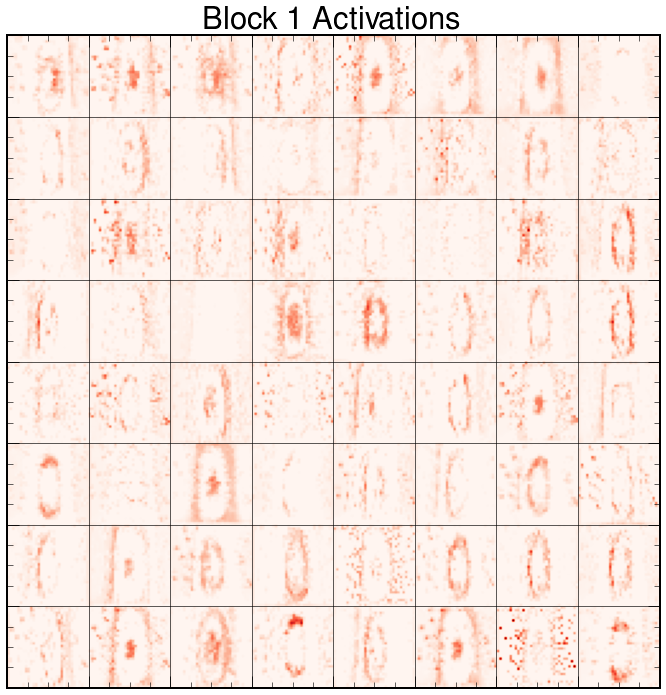

In [99]:
event = 11
fig, axs = plt.subplots(1, 1, figsize=(12, 12))
plt.setp(axs, 
         xticks=[0, 32, 64, 96, 128, 160, 192, 224, 256], xticklabels=[''],
         yticks=[0, 32, 64, 96, 128, 160, 192, 224, 256], yticklabels=[''])
extent = (0, 256, 256, 0)
axs.imshow(activations_1[event], cmap='Reds', origin='lower', extent=extent)
axs.set(title='Block 1 Activations')
plt.rc('grid', linestyle="-", color='black')
plt.grid()
plt.show()

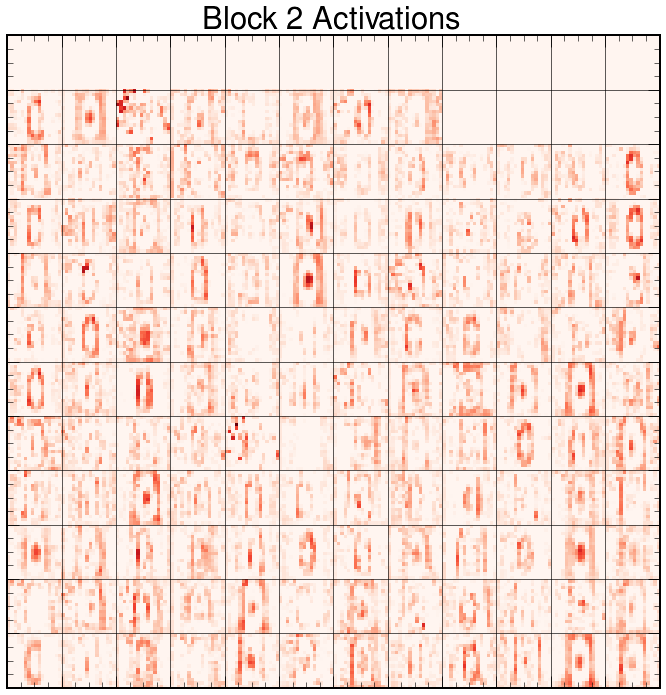

In [100]:
event = 11
fig, axs = plt.subplots(1, 1, figsize=(12, 12))
plt.setp(axs, 
         xticks=[0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192], xticklabels=[''],
         yticks=[0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192], yticklabels=[''])
extent = (0, 192, 192, 0)
axs.imshow(activations_2[event], cmap='Reds', origin='lower', extent=extent)
axs.set(title='Block 2 Activations')
plt.rc('grid', linestyle="-", color='black')
plt.grid()
plt.show()

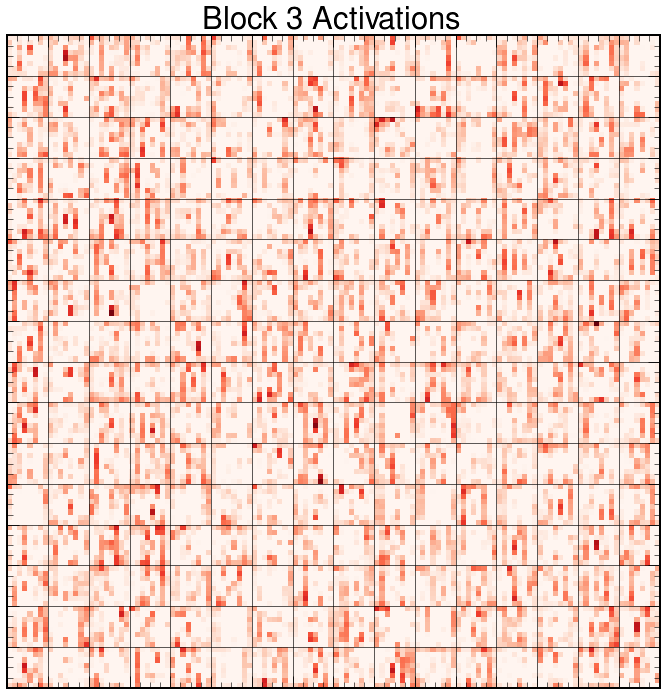

In [101]:
event = 11
fig, axs = plt.subplots(1, 1, figsize=(12, 12))
plt.setp(axs, 
    xticks=[0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128], 
    yticks=[0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128], 
    xticklabels=[''], 
    yticklabels=[''])
extent = (0, 128, 128, 0)
axs.imshow(activations_3[event], cmap='Reds', origin='lower', extent=extent)
axs.set(title='Block 3 Activations')
plt.rc('grid', linestyle="-", color='black')
plt.grid()
plt.show()